In [2]:
import os
import subprocess
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import re
from pymatgen.io.lammps.outputs import parse_lammps_log
import numpy as np

title = {'fontsize':20}
axes = {'fontsize':16}

## Already ran these, no need to rerun

In [3]:
monomer1 = "Dimethyl_Naphthalene_Dicarboximide" 
monomer2 = "Thiophene"
mod = ""
with open(f"{monomer1}-{monomer2}-scan-trj.{mod}.xyz", "w") as f:
    for phi in range(0,70,10):
        for theta in range(0,360,10):
            name=f"{monomer1}_Phi_{phi}_Theta_{theta}_{monomer2}.xyz"
            xyz = open(f"{mod}XYZ_Files/{name}").readlines()
            f.write("".join(xyz))

mod = "Hydrogenated"
with open(f"{monomer1}-{monomer2}-scan-trj.{mod}.xyz", "w") as f:
    for phi in range(0,70,10):
        for theta in range(0,360,10):
            name=f"{monomer1}_Phi_{phi}_Theta_{theta}_{monomer2}.xyz"
            xyz = open(f"{mod}_XYZ_Files/{name}").readlines()
            f.write("".join(xyz))

mod = "Hydrogenated_Improper"
with open(f"{monomer1}-{monomer2}-scan-trj.{mod}.xyz", "w") as f:
    for phi in range(0,70,10):
        for theta in range(0,360,10):
            name=f"{monomer1}_Phi_{phi}_Theta_{theta}_{monomer2}_{mod}.xyz"
            xyz = open(f"{mod}_XYZ_Files/{name}").readlines()
            f.write("".join(xyz))

FileNotFoundError: [Errno 2] No such file or directory: 'XYZ_Files/Dimethyl_Naphthalene_Dicarboximide_Phi_0_Theta_0_Thiophene.xyz'

In [ ]:
monomer1 = "Dimethyl_Naphthalene_Dicarboximide" 
monomer2 = "Thiophene"
mod = ""
with open(f"{monomer1}-{monomer2}-scan-trj.{mod}.xyz", "w") as f:
    for phi in range(0,70,10):
        for theta in range(0,360,10):
            name=f"{monomer1}_Phi_{phi}_Theta_{theta}_{monomer2}.xyz"
            xyz = open(f"{mod}XYZ_Files/{name}").readlines()
            f.write("".join(xyz))

mod = "Hydrogenated"
with open(f"{monomer1}-{monomer2}-scan-trj.{mod}.xyz", "w") as f:
    for phi in range(0,70,10):
        for theta in range(0,360,10):
            name=f"{monomer1}_Phi_{phi}_Theta_{theta}_{monomer2}.xyz"
            xyz = open(f"{mod}_XYZ_Files/{name}").readlines()
            f.write("".join(xyz))

mod = "Hydrogenated_Improper"
with open(f"{monomer1}-{monomer2}-scan-trj.{mod}.xyz", "w") as f:
    for phi in range(0,70,10):
        for theta in range(0,360,10):
            name=f"{monomer1}_Phi_{phi}_Theta_{theta}_{monomer2}_{mod}.xyz"
            xyz = open(f"{mod}_XYZ_Files/{name}").readlines()
            f.write("".join(xyz))

In [4]:
def check_QM_completion(e_dict):
    test = {}
    for phi in e_dict:
        test[phi]=[]
        for theta in e_dict[phi]:
            test[phi].append(theta)
    
    print(sorted(test.keys()))
    for i in sorted(test.keys()):
        print(i, len(test[i]))

def calc_deloc_energies(total_dict, hyd_dict, meth_dict):
    data = []
    for phi in total_dict:
        E_meth_min = np.min([meth_dict[phi][t] for t in meth_dict[phi]])
        E_hyd_min = np.min([hyd_dict[phi][t] for t in hyd_dict[phi]])
        E_tot_min = np.min([total_dict[phi][t] for t in total_dict[phi]])
        for theta in total_dict[phi]:
            # if theta >= 30:
                # print(phi,theta)
            # E_nonbond = (hyd_dict[phi][theta] - E_hyd_min) - (meth_dict[phi][theta] - E_meth_min)
            # E_nonbond = (hyd_dict[phi][theta] - hyd_dict[phi][0]) - (meth_dict[phi][theta] - meth_dict[phi][0])
            E_nonbond = hyd_dict[phi][theta] - meth_dict[phi][theta]
            E_deloc = (total_dict[phi][theta] - E_tot_min) - E_nonbond
            # E_deloc = (total_dict[phi][theta] - total_dict[phi][0]) - E_nonbond

            data.append([phi, theta, E_deloc, E_nonbond, hyd_dict[phi][theta], total_dict[phi][theta], meth_dict[phi][theta]])

    df = pd.DataFrame(data, columns=['Phi', 'Theta', 'E_deloc', 'E_nonbond', 'E_hyd', 'E_tot', 'E_meth'])
    sorted_df = df.sort_values(['Theta', 'Phi'])
    
    new_e_meth = []
    for phi in sorted_df['Phi'].unique():
        subset = sorted_df[sorted_df['Phi'] == phi]
        min = np.min(subset['E_meth'])
        norm = np.array(subset['E_meth'] - min)
        new_e_meth.append(norm)
    
    sorted_df['norm_E_meth'] = [i for sub in new_e_meth for i in sub]
    sorted_df['new_E_nb'] = sorted_df['E_hyd'] - sorted_df['norm_E_meth']
    sorted_df['new_E_deloc'] = sorted_df['E_tot'] - sorted_df['new_E_nb']
    
    return sorted_df

# Function to read XYZ coordinates
def read_xyz(filename):
    coords = []
    with open(filename, 'r') as f:
        for _ in range(2):  # Skip the first two lines
            next(f)
        for line in f:
            _, x, y, z = line.split()
            coords.append((float(x), float(y), float(z)))
    return coords

# Function to update LAMMPS data file with new coordinates
def update_lammps_data(lammps_file, new_coords, output_file):
    with open(lammps_file, 'r') as f_in, open(output_file, 'w') as f_out:
        atom_section = False
        i = 0  # Index for new_coords
        for line in f_in:
            if "Atoms" in line:
                atom_section = True
                f_out.write(line)
                next(f_in)  # Skip the empty line after "Atoms"
                f_out.write("\n")
                continue
            elif "Bonds" in line or "Velocities" in line:
                atom_section = False

            if atom_section:
                parts = line.split()
                if len(parts) > 4:  # Assuming id type x y z ...
                    new_line = f"{parts[0]} {parts[1]} {new_coords[i][0]} {new_coords[i][1]} {new_coords[i][2]} {' '.join(parts[5:])}\n"
                    f_out.write(new_line)
                    i += 1
                else:
                    f_out.write(line)
            else:
                f_out.write(line)

# Function to update LAMMPS data file with new coordinates
def update_lammps_data(lammps_file, new_coords, output_file):
    with open(lammps_file, 'r') as f_in, open(output_file, 'w') as f_out:
        atom_section = False
        i = 0  # Index for new_coords
        for line in f_in:
            if "Atoms" in line:                          
                atom_section = True
                f_out.write(line)
                next(f_in)  # Skip the empty line after "Atoms"
                f_out.write("\n")
                continue
            elif "Bonds" in line or "Velocities" in line:
                atom_section = False

            if atom_section:
                parts = line.split()
                if len(parts) == 7:  # id molecule_type atom_type charge x y z
                    new_line = f"{parts[0]}\t{parts[1]}\t{parts[2]}\t{parts[3]}\t{new_coords[i][0]:.6f}\t{new_coords[i][1]:.6f}\t{new_coords[i][2]:.6f}\n"
                    f_out.write(new_line)
                    i += 1
                else:
                    f_out.write(line)
            else:
                f_out.write(line)

def calc_TS_energies(total_dict, mm_dict):
    data = []
    for phi in total_dict:
        for theta in total_dict[phi]:
            if theta >= 30:
                # print(phi,theta)
                E_nonbond = mm_dict[phi][theta]
                E_TS = total_dict[phi][theta]*627.509 - E_nonbond
    
                data.append([phi, theta, E_TS, E_nonbond])

    df = pd.DataFrame(data, columns=['Phi', 'Theta', 'E_TS', 'E_nonbond'])
    return df

In [5]:
def plot_energy_dict(e_dict, units="rydberg", name = "RIMP2 energy"):
    """plots full torsional scans for all available improper angles phi
    
    args: 
        e_dict, dictionary of energies with following schema
            {phi0: {theta0: E0, theta1: E1, ...} ...}
            
        units, unit of energy from input e_dict
    """
    all_energies = [e_dict[phi][theta] for phi in e_dict for theta in e_dict[phi]]
    min = np.min(all_energies)
    for phi in e_dict:
        thetas = [theta for theta in e_dict[phi]]
        thetas = sorted(thetas)
        energies = [e_dict[phi][theta] for theta in thetas]
        if units == "rydberg":
            # convert to kcal/mol
            e_norm = [(e - min) * 627.509 for e in energies]
        elif units == "kcal":
            e_norm = [(e - min) for e in energies]
        else:
            raise Exception("Please use a supported energy unit")
        plt.plot(thetas, e_norm)
    plt.xlabel('Theta (degrees)')
    plt.ylabel('Total Energy (kcal/mol)')
    plt.title(f'Total {name} vs Theta for varying Phi')
    plt.show()

In [6]:
# Define a function for parsing QChem outfiles with structured naming scheme
def extract_qchem_energies(path, filename_pattern, energy_pattern):
    # Initialize nested dictionary
    data = {}
    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".out") and filename.startswith("Di"):
            # Extract phi and theta from filename
            match = filename_pattern.search(filename)
            if match:
                phi = int(match.group(1))
                theta = int(match.group(2))
    
                # Read file and search for energy
                with open(os.path.join(directory_path, filename), 'r') as f:
                    # print(filename)
                    energy_found = False
                    for line in f:
                        energy_match = energy_pattern.search(line)
                        if energy_match:
                            energy = float(energy_match.group(1))
    
                            # Store in nested dictionary
                            if phi not in data:
                                data[phi] = {}
                            data[phi][theta] = energy
    
                            energy_found = True
                            break
    
                    # Throw a warning if energy is not found
                    if not energy_found:
                        print(f"Warning: Energy not found in file {filename}")
            else:
                print(f"Warning: Could not extract Phi and Theta values from filename {filename}")
    return data

### Get Standard Scan Energies

In [7]:
# Specify directory to search for files
directory_path = "./rotation_run/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_total = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_total = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(rimp2_total)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


### Get Hydrogenated Scan Energies

In [8]:
# Specify directory to search for files
directory_path = "./hydrogenated-rotation-run/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_hyd = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_hyd = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(rimp2_hyd)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


### Get Methylated Scan Energies

In [9]:
# Specify directory to search for files
directory_path = "./methylated-rotation-run/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_meth = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_meth = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(rimp2_meth)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


In [10]:
energy_df = calc_deloc_energies(energy_total, energy_hyd, energy_meth)
rimp2_df = calc_deloc_energies(rimp2_total, rimp2_hyd, rimp2_meth)

In [15]:
from matplotlib.cm import viridis 
from matplotlib.colors import Normalize

phis = rimp2_df['Phi'].unique()
phis.sort()

cmap = viridis
norm = Normalize(vmin=np.min(phis), vmax=np.max(phis))

In [17]:
rimp2_df

,Phi,Theta,E_deloc,E_nonbond,E_hyd,E_tot,E_meth,norm_E_meth,new_E_nb,new_E_deloc
226,0,0,985.022084,-985.017982,-1576.391903,-1575.313175,-591.373922,0.002012,-1576.393915,1.080740
82,5,0,985.022087,-985.017791,-1576.391911,-1575.312791,-591.374120,0.002099,-1576.394010,1.081219
133,10,0,985.022000,-985.017460,-1576.390966,-1575.311546,-591.373506,0.002230,-1576.393195,1.081649
26,15,0,985.021869,-985.017055,-1576.389126,-1575.309438,-591.372071,0.002413,-1576.391539,1.082100
203,20,0,985.022601,-985.016478,-1576.386275,-1575.306427,-591.369797,0.002625,-1576.388900,1.082473
...,...,...,...,...,...,...,...,...,...,...
308,25,350,985.024624,-985.018471,-1576.384960,-1575.304402,-591.366489,0.012643,-1576.397603,1.093201
38,30,350,985.025919,-985.017708,-1576.380081,-1575.299528,-591.362373,0.013226,-1576.393307,1.093779
281,40,350,985.028331,-985.015077,-1576.366325,-1575.286203,-591.351249,0.012019,-1576.378345,1.092141
160,50,350,985.029958,-985.010276,-1576.346085,-1575.267291,-591.335809,0.009525,-1576.355610,1.088319


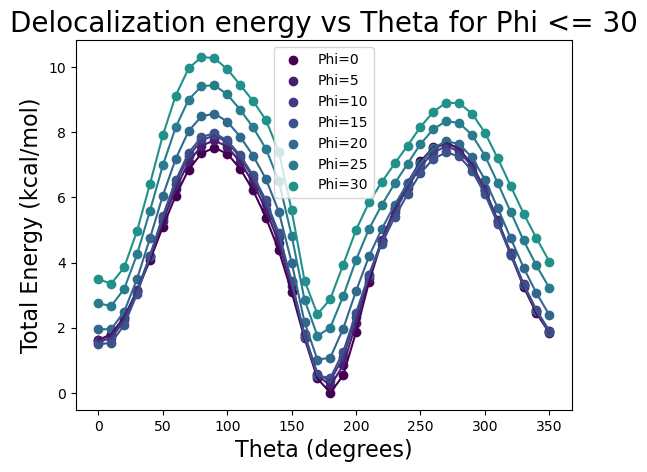

In [16]:
for phi in phis:
    if phi <= 30:
        subset = rimp2_df[rimp2_df['Phi'] == phi]
        min_energy = np.min(rimp2_df['E_deloc'])
        normed_energy = 627.509 * (subset['E_deloc'] - min_energy)  # Normalize energy
        energy = 627.509 * subset['E_deloc']

        # Map phi value to a color
        color = cmap(norm(phi))

        # Plot the normalized energy vs theta
        plt.plot(subset['Theta'], normed_energy, color=color)  # Replace 'E_total' with the actual column name for total energy
        plt.scatter(subset['Theta'], normed_energy, color=color, label=f"Phi={phi}")  # Replace 'E_total' with the actual column name for total energyy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
# plt.ylim(0,5)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.legend()
plt.show()

In [28]:
sorted_deloc.to_csv("sorted_deloc_energies.pndit.csv")

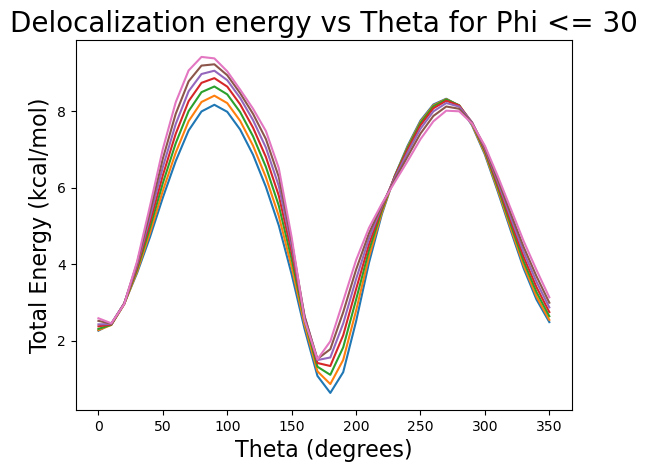

In [17]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
energies = sorted_rimp2_deloc['E_deloc']
min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 30:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        norm = [627.509*(i - min) for i in subset['E_deloc']]
        # norm = [627.509*i for i in subset['E_deloc']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

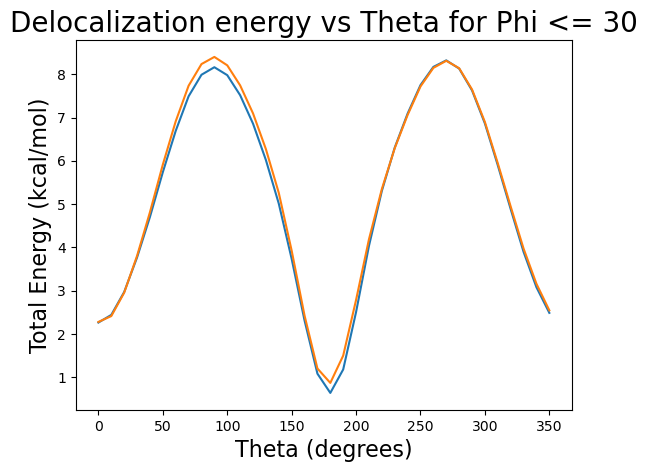

In [18]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
energies = sorted_rimp2_deloc['E_deloc']
min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 5:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        norm = [627.509*(i - min) for i in subset['E_deloc']]
        # norm = [627.509*i for i in subset['E_deloc']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

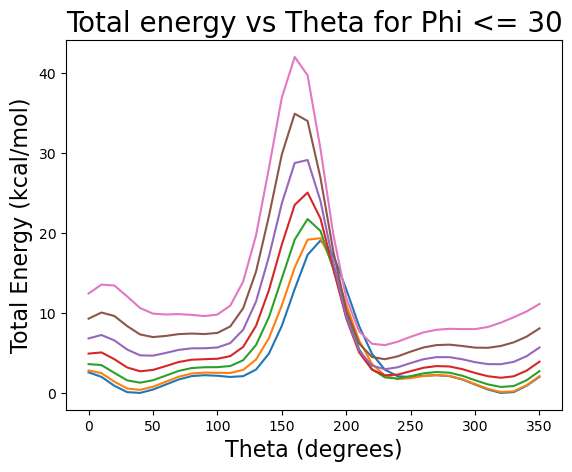

In [14]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
energies = sorted_rimp2_deloc['E_tot']
min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 30:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        norm = [627.509*(i - min) for i in subset['E_tot']]
        # norm = [627.509*i for i in subset['E_tot']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Total energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

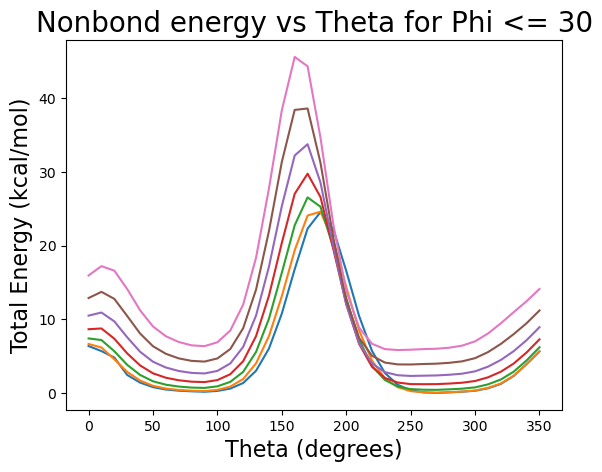

In [15]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
energies = sorted_rimp2_deloc['E_nonbond']
min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 30:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        norm = [627.509*(i - min) for i in subset['E_nonbond']]
        # norm = [627.509*i for i in subset['E_hyd']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Nonbond energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

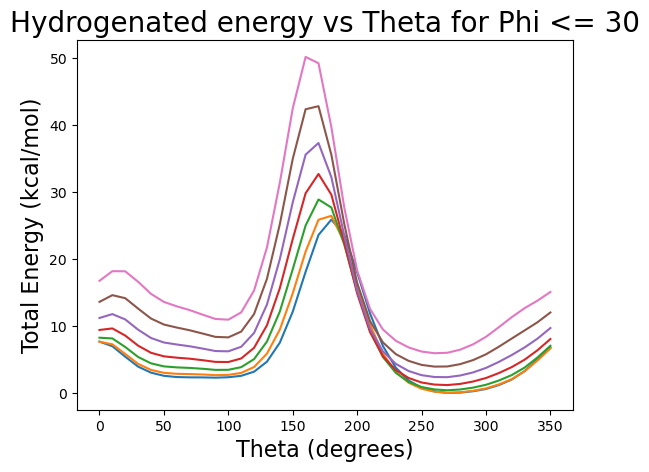

In [16]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
energies = sorted_rimp2_deloc['E_hyd']
min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 30:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        norm = [627.509*(i - min) for i in subset['E_hyd']]
        # norm = [627.509*i for i in subset['E_hyd']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Hydrogenated energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

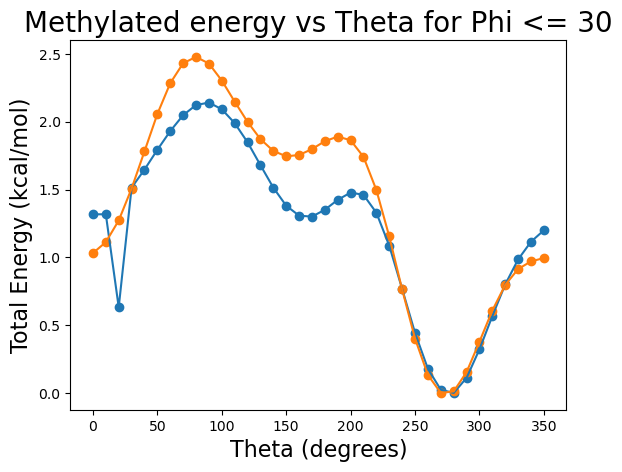

In [20]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
energies = sorted_rimp2_deloc['E_meth']
min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 5:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        norm = [627.509*(i - min) for i in subset['E_meth']]
        # norm = [627.509*i for i in subset['E_meth']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        plt.scatter(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Methylated energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

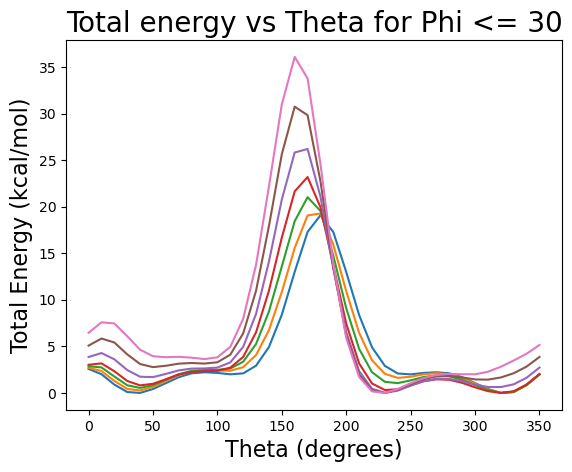

In [17]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
# energies = sorted_rimp2_deloc['E_meth']
# min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 30:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        min = np.min(subset['E_tot'])
        norm = [627.509*(i - min) for i in subset['E_tot']]
        # norm = [627.509*i for i in subset['E_meth']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Total energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

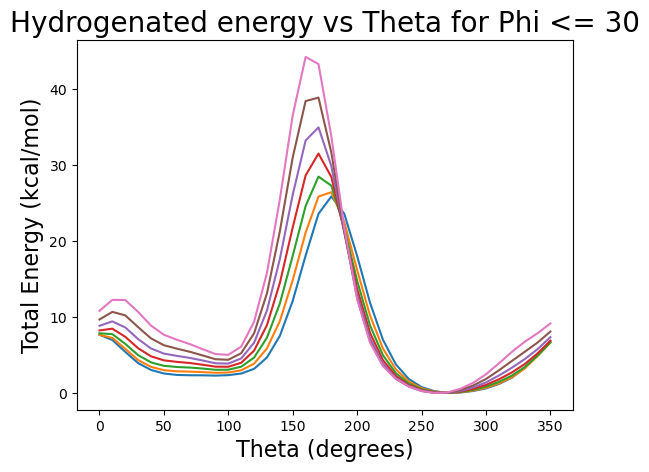

In [16]:
sorted_rimp2_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
# energies = sorted_rimp2_deloc['E_meth']
# min = np.min(energies)
for phi in set(sorted_rimp2_deloc['Phi']):
    if phi <= 30:
        subset = sorted_rimp2_deloc[sorted_rimp2_deloc['Phi'] == phi]
        min = np.min(subset['E_hyd'])
        norm = [627.509*(i - min) for i in subset['E_hyd']]
        # norm = [627.509*i for i in subset['E_meth']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Hydrogenated energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

In [19]:
test_df = calc_deloc_energies(rimp2_total, rimp2_hyd, rimp2_meth)

In [13]:
for phi in set(test_df['Phi']):
    if phi <= 30:
        subset = test_df[test_df['Phi'] == phi]
        # min = np.min(subset['E_meth'])
        # norm = [627.509*(i - min) for i in subset['E_meth']]
        norm = [627.509*i for i in subset['E_hyd']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

NameError: name 'test_df' is not defined

In [1]:
for phi in set(test_df['Phi']):
    if phi <= 30:
        subset = test_df[test_df['Phi'] == phi]
        min = np.min(test_df['E_deloc'])
        # norm = [627.509*(i - min) for i in subset['E_deloc']]
        norm = [627.509*i for i in subset['E_deloc']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        plt.scatter(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

NameError: name 'test_df' is not defined

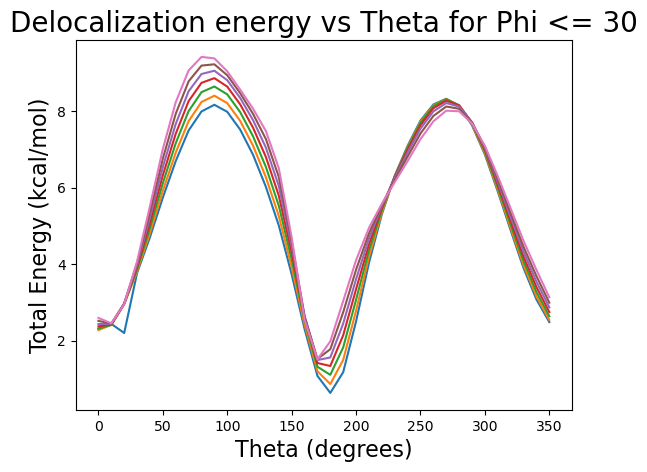

In [27]:
energies = sorted_rimp2_deloc['E_deloc']
min = np.min(energies)
for phi in set(test_df['Phi']):
    if phi <= 30:
        subset = test_df[test_df['Phi'] == phi]
        # min = np.min(subset['E_deloc'])
        norm = [627.509*(i - min) for i in subset['E_deloc']]
        # norm = [627.509*i for i in subset['E_deloc']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.show()

In [23]:
# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Initialize an empty DataFrame to hold all the data
all_data = pd.DataFrame()


files = os.listdir('./lammps_files_ligpargen/')
log_files = [file for file in files if file.endswith(".log")]

# Loop through log files
for filename in log_files:  # Replace with your log files directory
    match = filename_pattern.search(filename)
    if match:
        phi = int(match.group(1))
        theta = int(match.group(2))
        # Find the section with thermo data
        df = parse_lammps_log(os.path.join('./lammps_files_ligpargen/', filename))[0]
    
        # Add theta and phi columns (Assume you have a way to get these from the filename or file content)
        df['theta'] = theta  # Replace with actual value
        df['phi'] = phi  # Replace with actual value
    
        # Append to the overall DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)

# Convert to appropriate data types
all_data = all_data.apply(pd.to_numeric, errors='ignore')

# Sort by theta and phi
sorted_data = all_data.sort_values(['theta', 'phi'])

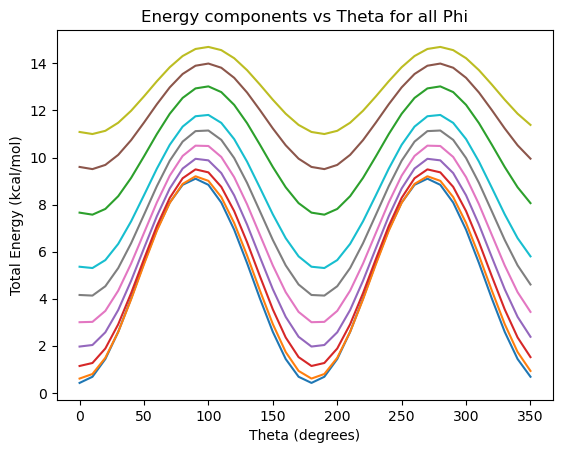

In [16]:
for phi in set(sorted_data['phi']):
    subset = sorted_data[sorted_data['phi'] == phi]
    # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
    plt.plot(subset['theta'], subset['E_dihed'])  # Replace 'E_total' with the actual column name for total energy
    # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
    # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)')
plt.ylabel('Total Energy (kcal/mol)')
plt.title(f'Energy components vs Theta for all Phi')
plt.show()

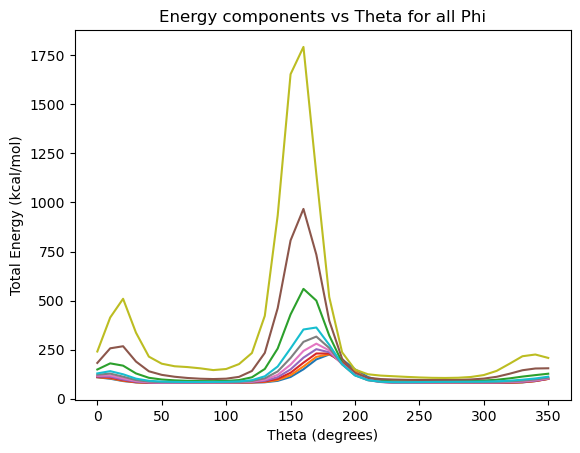

In [17]:
for phi in set(sorted_data['phi']):
    subset = sorted_data[sorted_data['phi'] == phi]
    # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
    plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
    # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
    # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)')
plt.ylabel('Total Energy (kcal/mol)')
plt.title(f'Energy components vs Theta for all Phi')
plt.show()

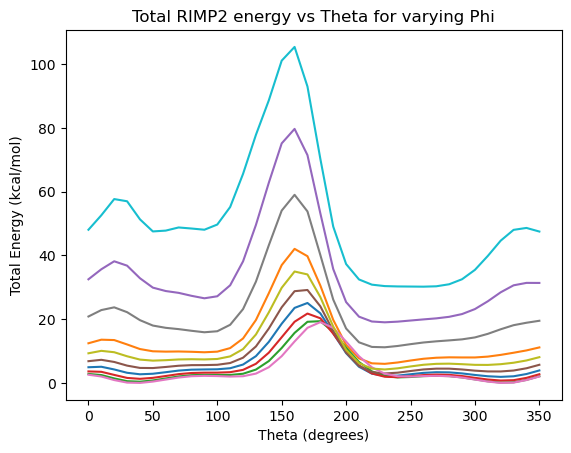

In [18]:
plot_energy_dict(rimp2_total)

In [19]:
def calc_TS_energies(total_dict, mm_dict):
    data = []
    for phi in total_dict:
        for theta in total_dict[phi]:
            if theta >= 30:
                # print(phi,theta)
                E_nonbond = mm_dict[phi][theta]
                E_TS = total_dict[phi][theta]*627.509 - E_nonbond
    
                data.append([phi, theta, E_TS, E_nonbond])

    df = pd.DataFrame(data, columns=['Phi', 'Theta', 'E_TS', 'E_nonbond'])
    return df

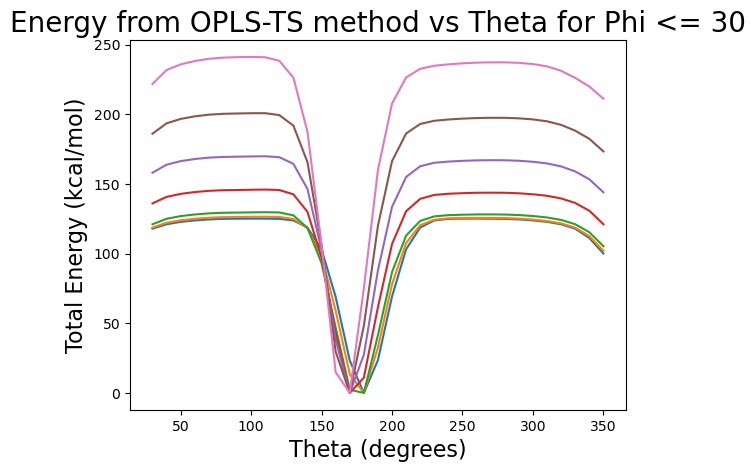

In [20]:
mm_dict = {}
for phi in set(sorted_data['phi']):
    subset = sorted_data[sorted_data['phi'] == phi]
    test = subset.to_dict()
    mm_dict[phi] = {}
    for i in test['phi']:
        theta = test['theta'][i]
        mm_dict[phi][theta] = test['E_vdwl'][i] + test['E_coul'][i] + test['E_long'][i]
        
test = calc_TS_energies(energy_total, mm_dict)
sorted_TS = test.sort_values(['Theta', 'Phi'])
for phi in set(sorted_TS['Phi']):
    if phi <= 30:
        subset = sorted_TS[sorted_TS['Phi'] == phi]
        min = np.min(subset['E_TS'])
        norm = [(i - min) for i in subset['E_TS']]
        # plt.plot(subset['theta'], subset['PotEng'])  # Replace 'E_total' with the actual column name for total energy
        plt.plot(subset['Theta'], norm)  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_dihed'], c="red")  # Replace 'E_total' with the actual column name for total energy
        # plt.plot(subset['theta'], subset['E_impro'], c="black")  # Replace 'E_total' with the actual column name for total energy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
plt.title(f'Energy from OPLS-TS method vs Theta for Phi <= 30', fontdict=title)
plt.show()